In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 6.0)

## paul

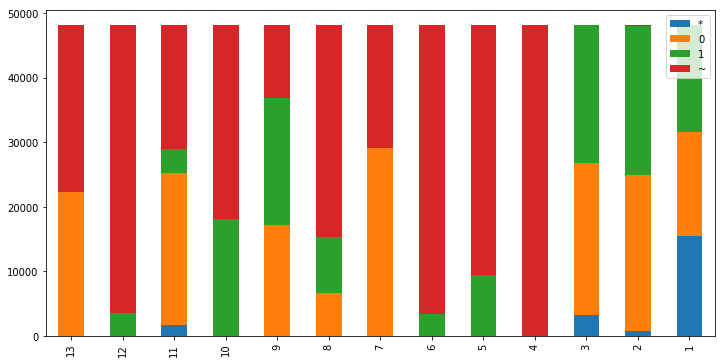

In [53]:
d = pd.read_csv("./output.txt", sep='\t', names=['sent', 's'])
params = d.s.str.strip().apply(list)
params = pd.DataFrame([list(x) for x in params])
params.columns = range(13, 0, -1)
a=params.apply(lambda x: x.value_counts(), axis=0).fillna(0)
a.T.plot.bar(stacked=True);

## william

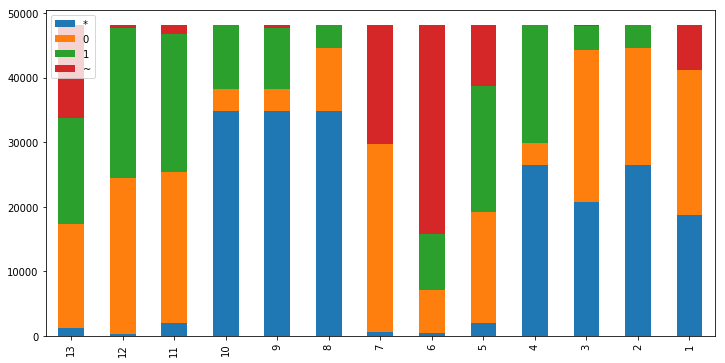

In [56]:
d = pd.read_csv("./COLAG_2011_sentID_rel.txt", sep='\t', names=['sent', 's'])
params = d.sent.str.strip().apply(list)
params = pd.DataFrame([list(x) for x in params])
params.columns = range(13, 0, -1)
a=params.apply(lambda x: x.value_counts(), axis=0).fillna(0)
a.T.plot.bar(stacked=True);

In [2]:
def int2binstr(i):
    return format(i, '013b')

data = pd.read_csv('./COLAG_2011_ids.txt', sep='\t')
data.columns = 'grammar sentence tree'.split()
sentences = pd.read_csv('./colag_2011_sents_w_freq.txt', sep='\t', header=None)
sentences = sentences[[1, 2]]
sentences.columns = ['type', 'string']
merged = pd.merge(data, sentences, left_on='sentence', right_index=True).sort_index()
merged['params'] = merged.grammar.apply(int2binstr)
merged.sample(5)

,grammar,sentence,tree,type,string,params
742240,1245,6053,616,DEC,S O1 P O3 Verb ...,0010011011101
1870028,3622,40267,20290,Q,S O1 Verb Never Aux ...,0111000100110
2356621,568,42279,74222,Q,S[+WA] ka Aux Not Verb O1 O2 Adv[+WH] ...,0001000111000
1999299,7180,3993,21458,DEC,O3 P Not S Verb ...,1110000001100
696102,1164,2060,5680,DEC,O1 S Verb Adv Aux ...,0010010001100


## Parses per sentence

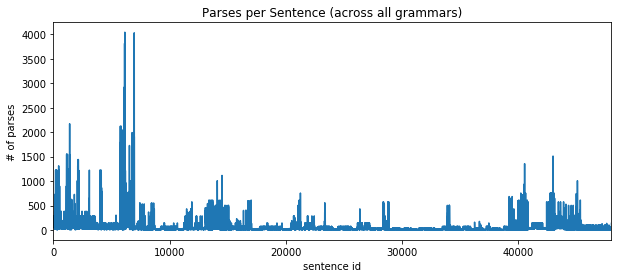

In [30]:
counts = data.groupby('sentence').size()
axis = counts.plot(title='Parses per Sentence (across all grammars)')
axis.set_xlabel('sentence id')
axis.set_ylabel('# of parses');

## Top 10 most parseable sentences

Number of parses across all grammars

In [37]:
x = merged.type + ' ' + merged.string
x.value_counts().head(20)

DEC S Verb Aux                                            4044
IMP Verb                                                  4032
DEC S Verb                                                3816
DEC S O1 Verb Never Aux                                   2916
DEC S Verb Not Aux                                        2916
DEC S O1 Verb Aux                                         2916
DEC S O1 Verb Not Aux                                     2916
DEC S Verb Never Aux                                      2916
DEC S O3 P Verb Not Aux                                   2448
DEC S O3 P Verb Never Aux                                 2448
DEC S O3 P O1 Verb Not Aux                                2448
DEC S O3 P O1 Verb Aux                                    2448
DEC S O3 P Verb Aux                                       2448
DEC S O3 P O1 Verb Never Aux                              2448
DEC Aux Verb S                                            2172
DEC S O2 O1 Verb Not Aux                               

In [42]:
len(data) - len(data.drop_duplicates(keep='first'))

296213

In [6]:
illegal_grammars = np.setdiff1d(np.arange(0, 2**13), merged.grammar)
illegal_grammars = np.vectorize(int2binstr)(illegal_grammars)

In [135]:
from typing import List

Grammar = str
Sentence = int
Tree = int

IrrGrammar = str
AmbGrammar = str

def parse(grammar: Grammar, sentence: Sentence) -> List[Tree]:
    """ Returns all the tree parses of `sentence` via `grammar` """
    return merged[(merged.params == grammar) & (merged.sentence == sentence)].tree.values

def generators(tree: Tree, exclude=None) -> List[Grammar]:
    """ Returns all the grammars that license `tree` """
    return merged[(merged.tree == tree) & (merged.params != exclude)].params.values

def flip(index, grammar):
    """ Flip bit at `index` in the bit string (a literal str) `grammar` """ 
    left, val, right = grammar[0:index], grammar[index], grammar[index+1:]
    val = '1' if val == '0' else '0'
    return ''.join([left, val, right])

def irrelevate(grammar: Grammar, tree: Tree) -> IrrGrammar:
    other_grammars = generators(tree, exclude=grammar)
    result = []
    for index, value in enumerate(grammar):
        # grammar is a string of 1s and 0s. value is '1' or '0'
        flipped = flip(index, grammar)
        if flipped in other_grammars or flipped in illegal_grammars:
            result.append('~')
        else:
            result.append(value)
    return ''.join(result)    

def ambiguate_column(col):
    if '~' in col:
         return '~'
    return col[0] if len(set(col)) == 1 else '*'

def ambiguate(grammars: List[IrrGrammar]):
    slots = zip(*grammars)
    return ''.join([ambiguate_column(val)
                   for val in slots])

def learn(row):
    params, sentence, tree = merged[['params', 'sentence', 'tree']]
    return ambiguate([irrelevate(gr)])

# merged.head(10).apply(learn, axis=1)

# # gnum, grammar, sentence = merged.sample(1)[['grammar', 'params', 'sentence']].values[0]
# gnum, grammar, sentence = gnum, grammar, sentence
# #grammar, sentence = (int2binstr(3588), 5794)
# trees = parse(grammar, sentence)
# pd.DataFrame({
#     'sentence': sentence,
#     'grammar': gnum, 
#     'params': grammar, 
#     'tree': trees, 
#     'result':[irrelevate(grammar, tree) for tree in trees]
# })
irrelevate(grammar, sentence)

'000~~1~~~~0~~'

In [33]:
len(illegal_grammars)

5120

In [8]:
merged[merged.tree==3375]

,grammar,sentence,tree,type,string,params
0,132,1282,3375,DEC,Aux S Not Verb ...,0000010000100
87,132,1282,3375,DEC,Aux S Not Verb ...,0000010000100
210,132,1282,3375,DEC,Aux S Not Verb ...,0000010000100
406,132,14002,3375,Q,Aux S Not Verb ...,0000010000100
1230,133,1282,3375,DEC,Aux S Not Verb ...,0000010000101
1317,133,1282,3375,DEC,Aux S Not Verb ...,0000010000101
1440,133,1282,3375,DEC,Aux S Not Verb ...,0000010000101
1636,133,14002,3375,Q,Aux S Not Verb ...,0000010000101
2460,134,1282,3375,DEC,Aux S Not Verb ...,0000010000110
2547,134,1282,3375,DEC,Aux S Not Verb ...,0000010000110
